In [31]:
# 1. Import Libraries and Setup
import pandas as pd
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk import bigrams
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
# 2. Load Metadata File in Chunks and Filter for Asian Category
meta_chunks = []
chunksize = 10000
for chunk in pd.read_json('meta_Grocery_and_Gourmet_Food.json.gz', compression='gzip', lines=True, chunksize=chunksize):
    meta_chunks.append(chunk)
meta_df = pd.concat(meta_chunks, axis=0)
asian_mask = meta_df['category'].apply(lambda x: "Asian" in x)
asian_meta = meta_df[asian_mask]
asian_asins = list(asian_meta['asin'].unique())

In [33]:
# 3. Load Review Data Filtered by ASINs
review_chunks = []
chunksize = 100000
for chunk in pd.read_json('Grocery_and_Gourmet_Food_5.json.gz', compression='gzip', lines=True, chunksize=chunksize):
    review_chunk = chunk[chunk['asin'].isin(asian_asins)]
    review_chunks.append(review_chunk)
myData = pd.concat(review_chunks, axis=0)
myData.to_csv('myAsianFood.csv', sep='|', escapechar='\\', index=False)

In [34]:
# 4. Sentiment Analysis Setup and Score Calculation
sia = SentimentIntensityAnalyzer()
myData['reviewText'] = myData['reviewText'].astype(str)
myData['clean_review'] = myData['reviewText'].str.replace("[^a-zA-Z']", " ", regex=True).str.strip()
myData['sentiment_score'] = myData['clean_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
def getSentimentCategory(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'
myData['sentiment_cat'] = myData['sentiment_score'].apply(getSentimentCategory)

In [37]:
import re
from nltk.corpus import stopwords

def clean_and_tokenise(text_series):
    # Combine all reviews into one string
    all_text = ' '.join(text_series)

    # Use regex to split into words (only words with 4+ letters)
    tokens = re.findall(r'\b[a-zA-Z]{4,}\b', all_text.lower())

    # Remove English stopwords
    stopwords_en = set(stopwords.words('english'))
    clean_tokens = [word for word in tokens if word not in stopwords_en]

    return clean_tokens

In [39]:
# 5. Tokenisation and Frequency Analysis

# Positive
pos_reviews = myData[myData['sentiment_cat'] == 'positive']['clean_review']
pos_tokens = clean_and_tokenise(pos_reviews)
pos_freq = FreqDist(pos_tokens)
pos_df = pd.DataFrame(pos_freq.most_common(30), columns=['word', 'frequency'])
pos_string = ' '.join(pos_tokens)
pos_bigrams = list(itertools.chain.from_iterable([list(bigrams(re.findall(r'\b[a-zA-Z]{4,}\b', t.lower()))) for t in pos_reviews]))
pos_bigram_freq = FreqDist(pos_bigrams)

# Negative
neg_reviews = myData[myData['sentiment_cat'] == 'negative']['clean_review']
neg_tokens = clean_and_tokenise(neg_reviews)
neg_freq = FreqDist(neg_tokens)
neg_df = pd.DataFrame(neg_freq.most_common(30), columns=['word', 'frequency'])
neg_string = ' '.join(neg_tokens)
neg_bigrams = list(itertools.chain.from_iterable([list(bigrams(re.findall(r'\b[a-zA-Z]{4,}\b', t.lower()))) for t in neg_reviews]))
neg_bigram_freq = FreqDist(neg_bigrams)

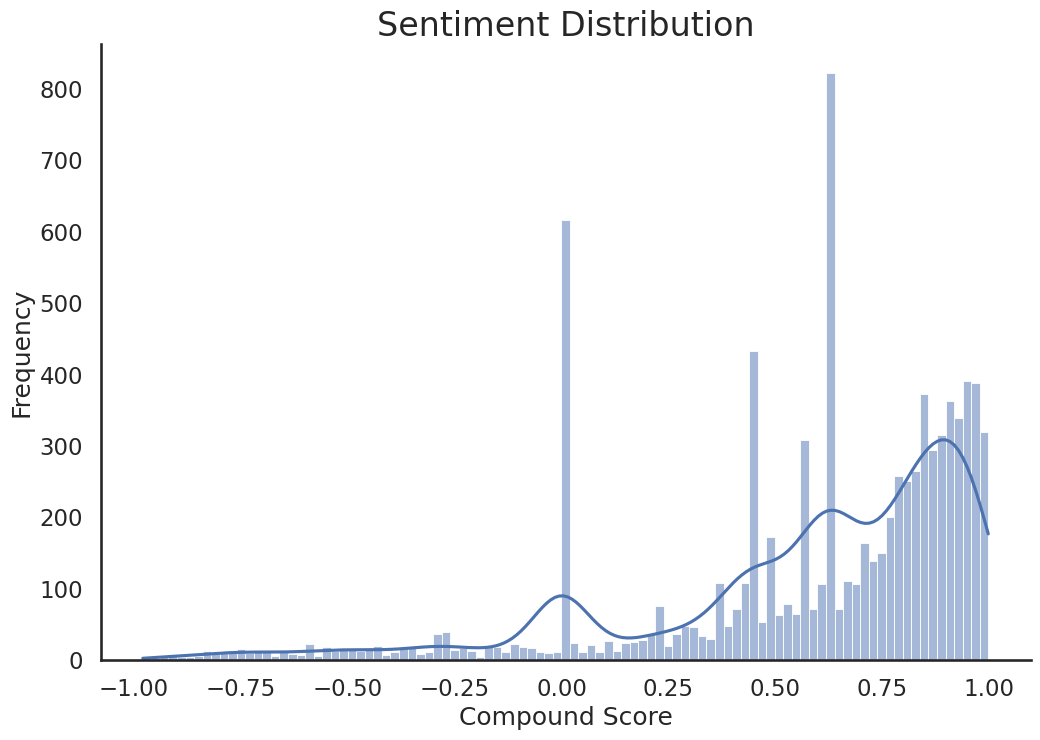

In [40]:
# 6. Sentiment Score Distribution
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(12,8))
sns.histplot(myData['sentiment_score'], kde=True, binwidth=0.02)
plt.xlabel("Compound Score")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution", fontsize=24)
sns.despine()
plt.savefig("sentDist.png", bbox_inches="tight", dpi=200)
plt.show()

/tmp/ipython-input-41-3221524541.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x="frequency", y="word", ax=ax[0], palette="rocket")
/tmp/ipython-input-41-3221524541.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neg_df, x="frequency", y="word", ax=ax[1], palette="mako")


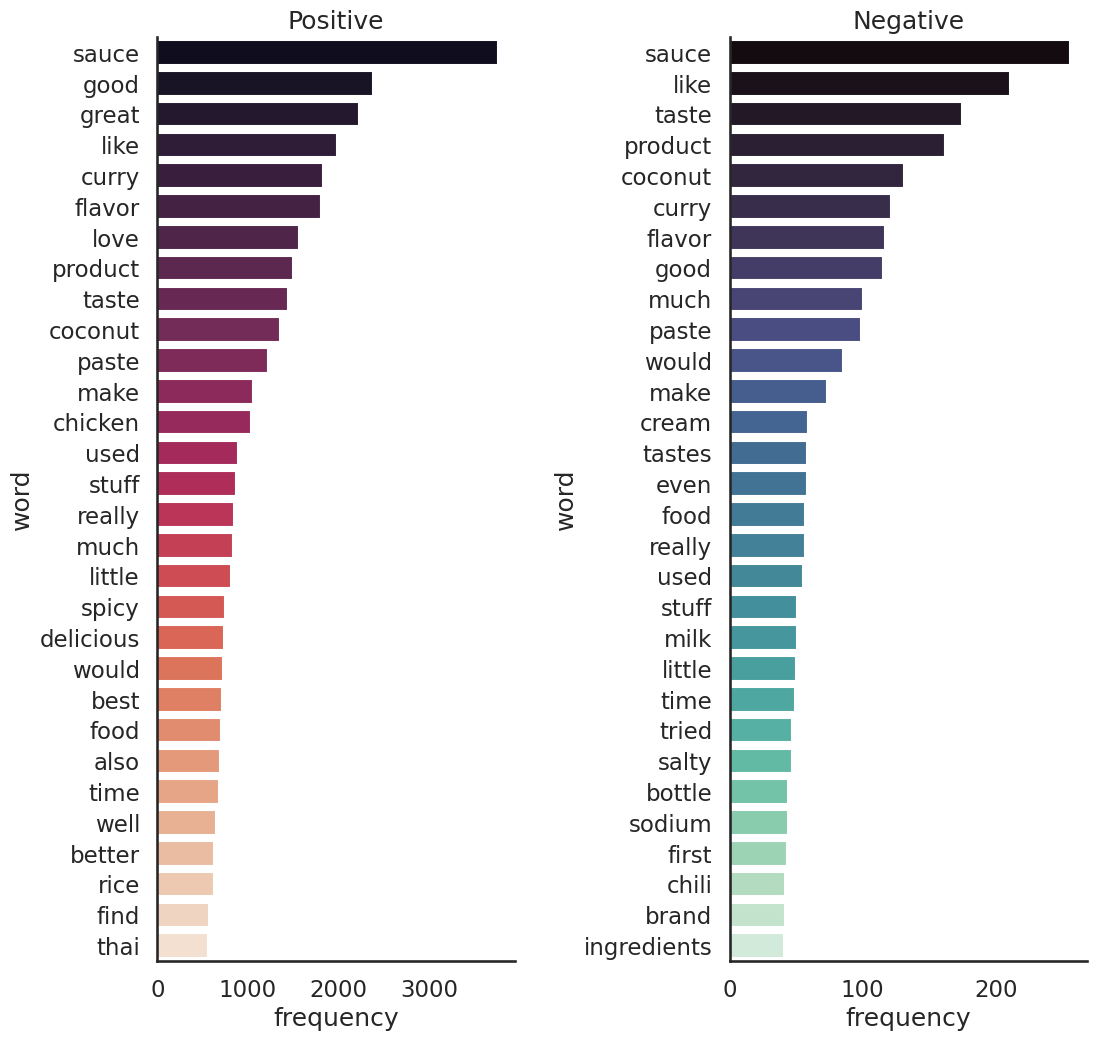

In [41]:
# 7. Barplot Word Frequency
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
sns.barplot(data=pos_df, x="frequency", y="word", ax=ax[0], palette="rocket")
ax[0].set_title('Positive')
sns.barplot(data=neg_df, x="frequency", y="word", ax=ax[1], palette="mako")
ax[1].set_title('Negative')
plt.subplots_adjust(wspace=0.6)
sns.despine()
plt.savefig("conditionalWordFreq.png", bbox_inches='tight', dpi=400)
plt.show()

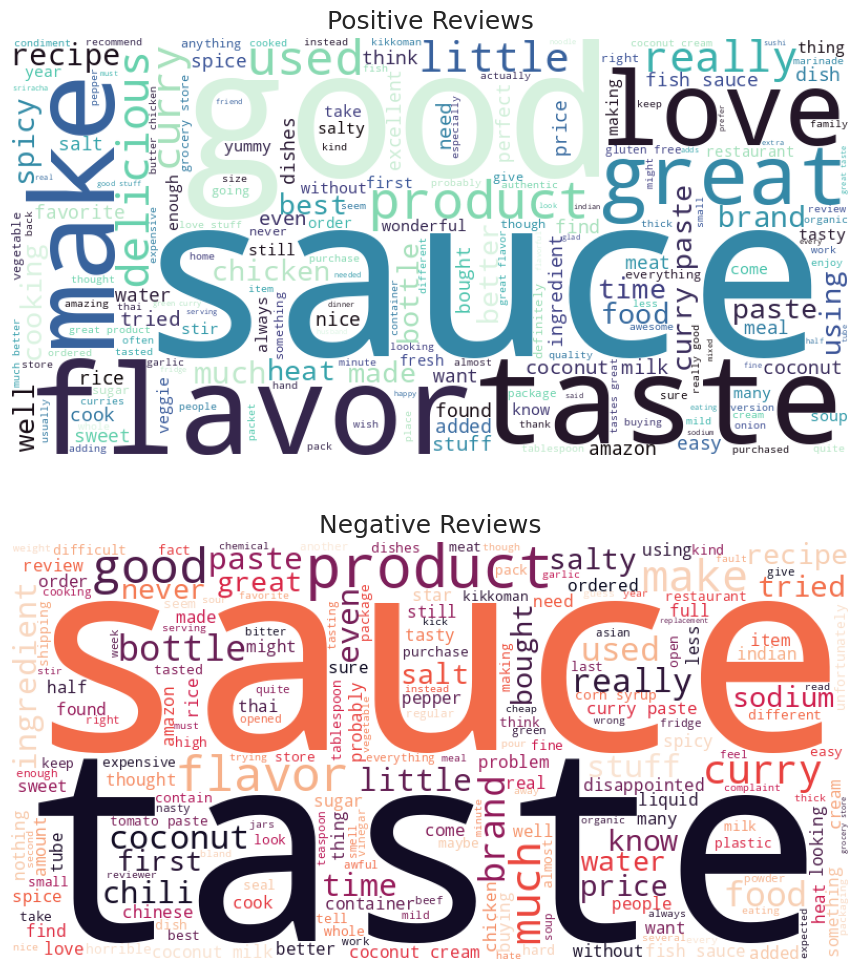

In [42]:
# 8. Word Cloud
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
pos_cloud = WordCloud(width=800, height=400, background_color='white', colormap='mako').generate(pos_string)
ax[0].imshow(pos_cloud); ax[0].axis("off"); ax[0].set_title("Positive Reviews")
neg_cloud = WordCloud(width=800, height=400, background_color='white', colormap='rocket').generate(neg_string)
ax[1].imshow(neg_cloud); ax[1].axis("off"); ax[1].set_title("Negative Reviews")
plt.savefig("conditionalWordcloud.png", bbox_inches='tight', dpi=400)
plt.show()

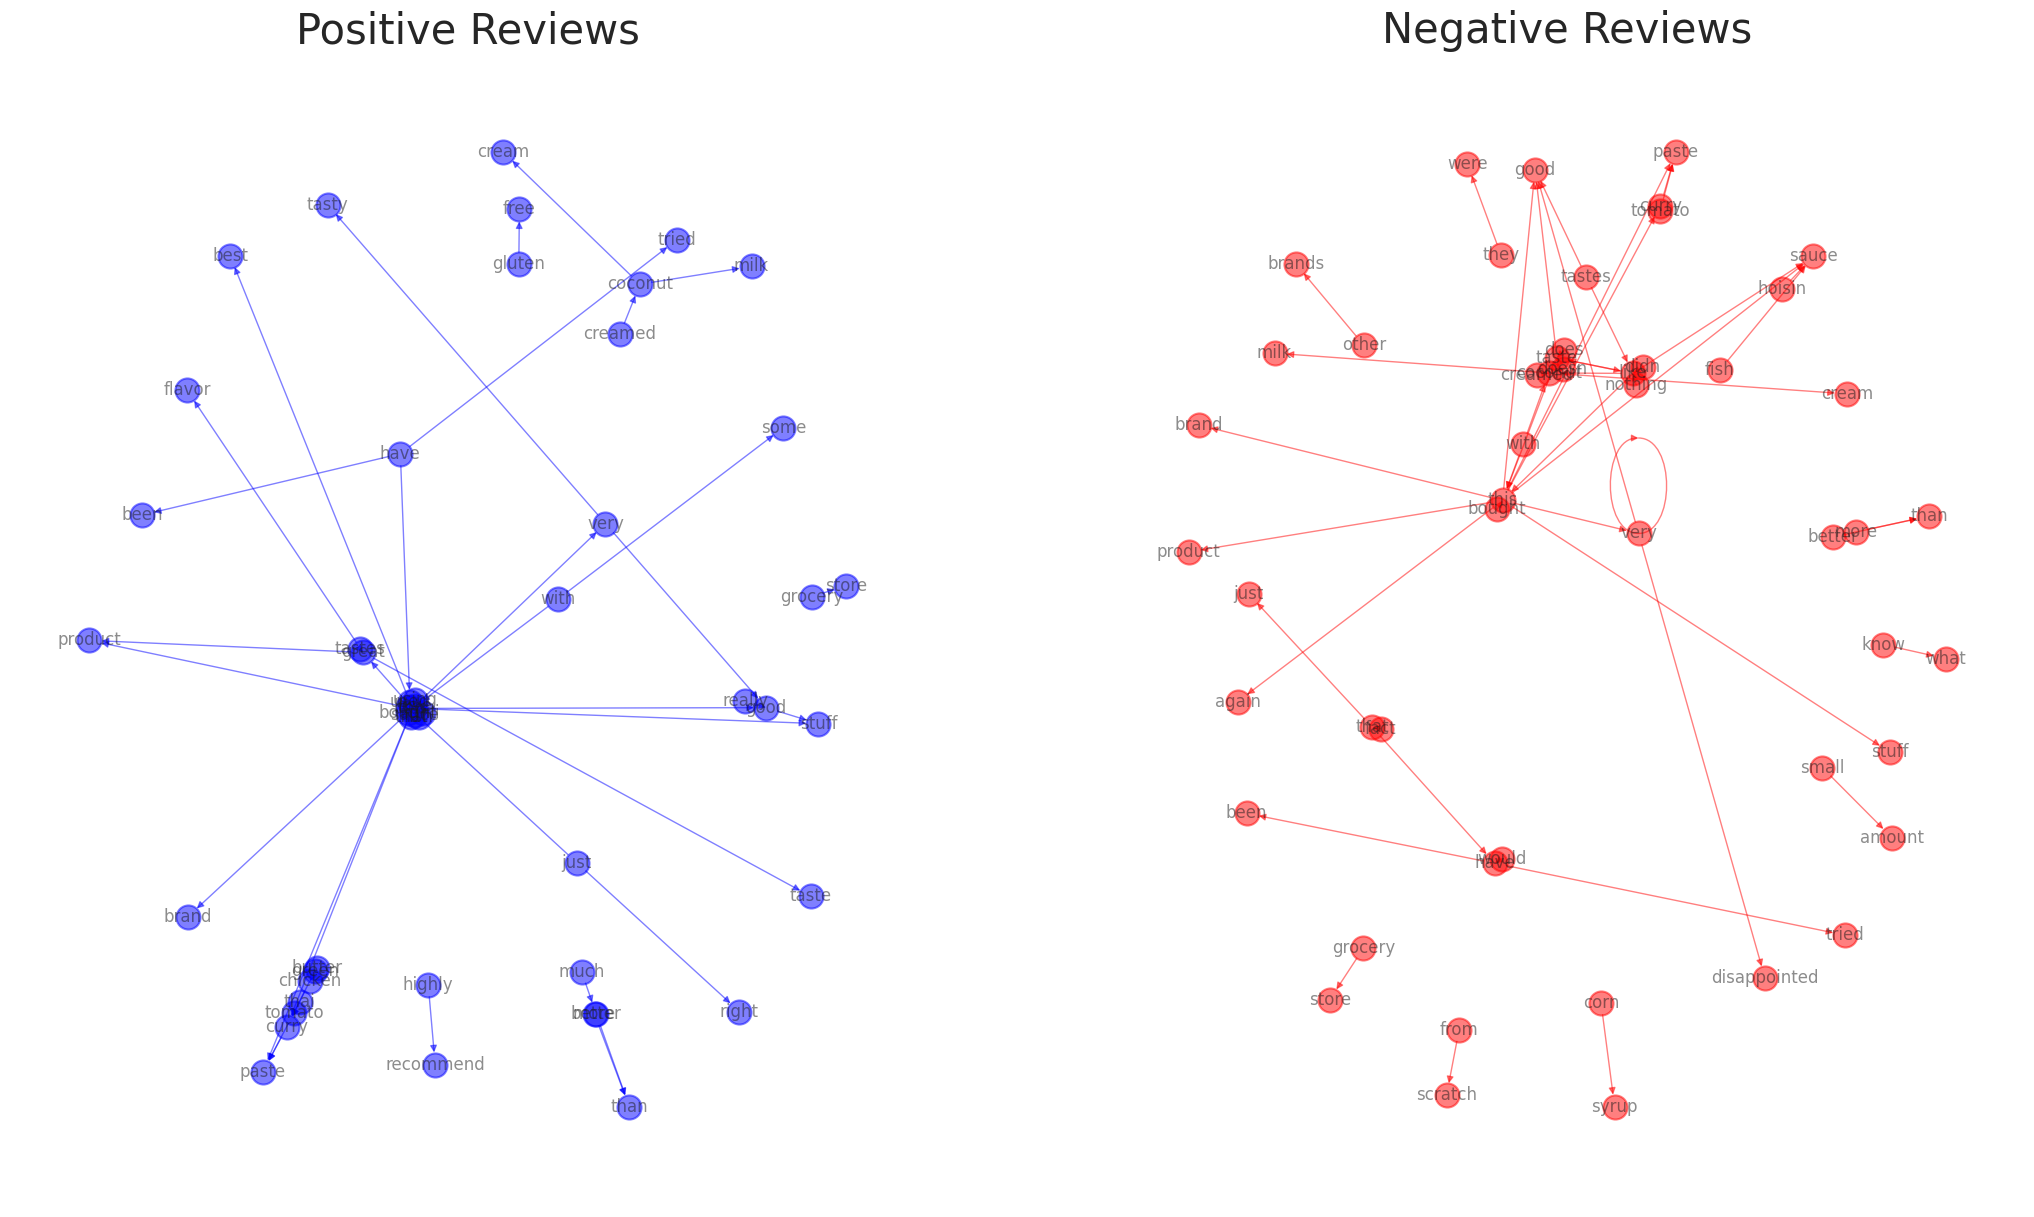

In [43]:
# 9. Bigram Network Visualisation
G_pos = nx.DiGraph()
for i in pos_bigram_freq.most_common(50):
    G_pos.add_edge(i[0][0], i[0][1], weight=i[1])
G_neg = nx.DiGraph()
for i in neg_bigram_freq.most_common(50):
    G_neg.add_edge(i[0][0], i[0][1], weight=i[1])
fig, ax = plt.subplots(1, 2, figsize=(26, 15))
pos_layout = nx.spring_layout(G_pos)
nx.draw_networkx(G_pos, pos=pos_layout, ax=ax[0], node_color="blue", edge_color="blue", alpha=0.5, with_labels=True)
ax[0].axis("off")
ax[0].set_title('Positive Reviews', fontsize=30)
neg_layout = nx.spring_layout(G_neg)
nx.draw_networkx(G_neg, pos=neg_layout, ax=ax[1], node_color="red", edge_color="red", alpha=0.5, with_labels=True)
ax[1].axis("off")
ax[1].set_title('Negative Reviews', fontsize=30)
plt.savefig('directedBigram.png', bbox_inches='tight', dpi=400)
plt.show()